# Task
Analyze the household power consumption dataset to forecast short-term energy usage. Parse and resample the time series data, engineer time-based features, compare the performance of ARIMA, Prophet, and XGBoost models using MAE and RMSE, and plot actual vs. forecasted energy usage.

## Load and preprocess data

### Subtask:
Load the dataset, parse the date and time columns, and resample the data to a suitable frequency (e.g., hourly or daily).


In [4]:
# Read the first few lines of the raw file to inspect the format
with open('/content/household_power_consumption.csv', 'r') as f:
    for i in range(5):
        print(f.readline())

index,Date,Time,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3

0,1/1/07,0:00:00,2.58,0.136,241.97,10.6,0,0,0.0

1,1/1/07,0:01:00,2.552,0.1,241.75,10.4,0,0,0.0

2,1/1/07,0:02:00,2.55,0.1,241.64,10.4,0,0,0.0

3,1/1/07,0:03:00,2.55,0.1,241.71,10.4,0,0,0.0



**Reasoning**:
The inspection of the raw data shows that the separator is a comma, not a semicolon, and there's an extra 'index' column. Reload the dataset with the correct separator and drop the 'index' column, then combine date and time, set index, convert columns to numeric, handle missing values, and resample the data.



In [5]:
# Reload the dataset with the correct separator (comma) and drop the 'index' column
df = pd.read_csv(
    '/content/household_power_consumption.csv',
    sep=',',
    low_memory=False
)

# Drop the extra 'index' column
df.drop('index', axis=1, inplace=True)

# Combine 'Date' and 'Time' columns and convert to datetime
df['datetime'] = pd.to_datetime(df['Date'] + ' ' + df['Time'], dayfirst=True)

# Set the combined datetime column as the index
df.set_index('datetime', inplace=True)

# Drop the original 'Date' and 'Time' columns
df.drop(['Date', 'Time'], axis=1, inplace=True)

# Convert power consumption columns to numeric, coercing errors to NaN
for col in ['Global_active_power', 'Global_reactive_power', 'Voltage', 'Global_intensity', 'Sub_metering_1', 'Sub_metering_2', 'Sub_metering_3']:
    df[col] = pd.to_numeric(df[col], errors='coerce')

# Handle missing values using forward fill
df.fillna(method='ffill', inplace=True)

# Resample the data to hourly frequency, aggregating by mean
df_resampled = df.resample('H').mean()

display(df_resampled.head())
display(df_resampled.info())

/tmp/ipython-input-5-3645423447.py:12: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df['datetime'] = pd.to_datetime(df['Date'] + ' ' + df['Time'], dayfirst=True)
/tmp/ipython-input-5-3645423447.py:25: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df.fillna(method='ffill', inplace=True)
/tmp/ipython-input-5-3645423447.py:28: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  df_resampled = df.resample('H').mean()


,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3
datetime,,,,,,,
2007-01-01 00:00:00,2.550633,0.112800,241.361333,10.530000,0.0,0.583333,0.0
2007-01-01 01:00:00,2.523400,0.071633,241.096500,10.443333,0.0,0.000000,0.0
2007-01-01 02:00:00,2.582333,0.106667,243.200167,10.540000,0.0,0.333333,0.0
2007-01-01 03:00:00,2.541667,0.090100,243.265667,10.400000,0.0,0.266667,0.0
2007-01-01 04:00:00,2.475733,0.088167,242.456167,10.110000,0.0,0.000000,0.0


<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 4344 entries, 2007-01-01 00:00:00 to 2007-06-30 23:00:00
Freq: h
Data columns (total 7 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   Global_active_power    4344 non-null   float64
 1   Global_reactive_power  4344 non-null   float64
 2   Voltage                4344 non-null   float64
 3   Global_intensity       4344 non-null   float64
 4   Sub_metering_1         4344 non-null   float64
 5   Sub_metering_2         4344 non-null   float64
 6   Sub_metering_3         4344 non-null   float64
dtypes: float64(7)
memory usage: 271.5 KB


None

## Feature engineering

### Subtask:
Create time-based features such as hour of the day, day of the week, day of the month, and month of the year.


**Reasoning**:
Extract hour, day of week, day of month, and month of year from the datetime index and display the head of the dataframe to verify the new columns.



In [6]:
df_resampled['hour'] = df_resampled.index.hour
df_resampled['dayofweek'] = df_resampled.index.dayofweek
df_resampled['dayofmonth'] = df_resampled.index.day
df_resampled['month'] = df_resampled.index.month

display(df_resampled.head())

,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3,hour,dayofweek,dayofmonth,month
datetime,,,,,,,,,,,
2007-01-01 00:00:00,2.550633,0.112800,241.361333,10.530000,0.0,0.583333,0.0,0,0,1,1
2007-01-01 01:00:00,2.523400,0.071633,241.096500,10.443333,0.0,0.000000,0.0,1,0,1,1
2007-01-01 02:00:00,2.582333,0.106667,243.200167,10.540000,0.0,0.333333,0.0,2,0,1,1
2007-01-01 03:00:00,2.541667,0.090100,243.265667,10.400000,0.0,0.266667,0.0,3,0,1,1
2007-01-01 04:00:00,2.475733,0.088167,242.456167,10.110000,0.0,0.000000,0.0,4,0,1,1


## Model selection and training

### Subtask:
Split the data into training and testing sets and train ARIMA, Prophet, and XGBoost models on the training data.


**Reasoning**:
Define the target variable, split the data into training and testing sets, train ARIMA, Prophet, and XGBoost models on the training data.



In [7]:
from statsmodels.tsa.arima.model import ARIMA
from prophet import Prophet
from xgboost import XGBRegressor
from sklearn.model_selection import train_test_split

# 1. Define the target variable
target = 'Global_active_power'

# 2. Split the df_resampled dataframe into training and testing sets (80/20 split)
train_size = int(len(df_resampled) * 0.8)
train_data = df_resampled[:train_size].copy()
test_data = df_resampled[train_size:].copy()

# 3. Train an ARIMA model
# Using a simple (5,1,0) order as an initial guess. More rigorous order selection can be done using auto_arima or ACF/PACF plots.
arima_model = ARIMA(train_data[target], order=(5, 1, 0))
arima_model_fit = arima_model.fit()
print("ARIMA model trained.")

# 4. Train a Prophet model
# Prophet requires columns named 'ds' (datetime) and 'y' (target)
prophet_train_data = train_data.reset_index()[['datetime', target]].rename(columns={'datetime': 'ds', target: 'y'})
prophet_model = Prophet()
prophet_model.fit(prophet_train_data)
print("Prophet model trained.")

# 5. Prepare the training data for the XGBoost model
# Drop the target variable and use the engineered features
features = ['hour', 'dayofweek', 'dayofmonth', 'month']
X_train = train_data[features]
y_train = train_data[target]

# 6. Train an XGBoost Regressor model
xgboost_model = XGBRegressor(objective='reg:squarederror', n_estimators=1000, learning_rate=0.05, n_jobs=-1)
xgboost_model.fit(X_train, y_train)
print("XGBoost model trained.")

ARIMA model trained.


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp5sickivv/uia6b5l_.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp5sickivv/ysxijzwv.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=27865', 'data', 'file=/tmp/tmp5sickivv/uia6b5l_.json', 'init=/tmp/tmp5sickivv/ysxijzwv.json', 'output', 'file=/tmp/tmp5sickivv/prophet_model5uw2zbew/prophet_model-20250722212925.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
21:29:25 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
21:29:25 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


Prophet model trained.
XGBoost model trained.


## Model evaluation

### Subtask:
Evaluate the performance of each model using appropriate metrics such as Mean Absolute Error (MAE) and Root Mean Squared Error (RMSE).


**Reasoning**:
Generate predictions for each model on the test data and calculate the MAE and RMSE for each model to evaluate their performance.



In [10]:
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np

# 1. Generate predictions on the test data
# ARIMA predictions
# The forecast method requires the number of steps to forecast, which is the length of the test data
arima_predictions = arima_model_fit.forecast(steps=len(test_data))

# Prophet predictions
# Prophet requires a dataframe with future dates
future = prophet_model.make_future_dataframe(periods=len(test_data), freq='H')
prophet_predictions = prophet_model.predict(future)['yhat']

# Filter Prophet predictions to match the test data period
prophet_predictions = prophet_predictions[-len(test_data):]

# XGBoost predictions
# Prepare the test data for XGBoost
X_test = test_data[features]
xgboost_predictions = xgboost_model.predict(X_test)

# 2. Calculate MAE and RMSE for each model
y_test = test_data[target]

# ARIMA evaluation
arima_mae = mean_absolute_error(y_test, arima_predictions)
arima_rmse = np.sqrt(mean_squared_error(y_test, arima_predictions))

# Prophet evaluation
prophet_mae = mean_absolute_error(y_test, prophet_predictions)
prophet_rmse = np.sqrt(mean_squared_error(y_test, prophet_predictions))

# XGBoost evaluation
xgboost_mae = mean_absolute_error(y_test, xgboost_predictions)
xgboost_rmse = np.sqrt(mean_squared_error(y_test, xgboost_predictions))

# 3. Store the metrics
performance_metrics = {
    'ARIMA': {'MAE': arima_mae, 'RMSE': arima_rmse},
    'Prophet': {'MAE': prophet_mae, 'RMSE': prophet_rmse},
    'XGBoost': {'MAE': xgboost_mae, 'RMSE': xgboost_rmse}
}

# 4. Print the metrics
print("Model Performance Metrics:")
for model, metrics in performance_metrics.items():
    print(f"{model}:")
    print(f"  MAE: {metrics['MAE']:.4f}")
    print(f"  RMSE: {metrics['RMSE']:.4f}")

/usr/local/lib/python3.11/dist-packages/prophet/forecaster.py:1872: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  dates = pd.date_range(


Model Performance Metrics:
ARIMA:
  MAE: 0.7598
  RMSE: 0.8807
Prophet:
  MAE: 0.5794
  RMSE: 0.7527
XGBoost:
  MAE: 0.5859
  RMSE: 0.8071


## Forecasting and visualization

### Subtask:
Generate forecasts using the trained models and visualize the actual versus forecasted energy usage.


**Reasoning**:
Generate forecasts for the test set using the trained ARIMA, Prophet, and XGBoost models and visualize the actual versus forecasted energy usage by plotting the actual test data and the predictions from each model on the same plot with appropriate labels and a legend.



/usr/local/lib/python3.11/dist-packages/prophet/forecaster.py:1872: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  dates = pd.date_range(


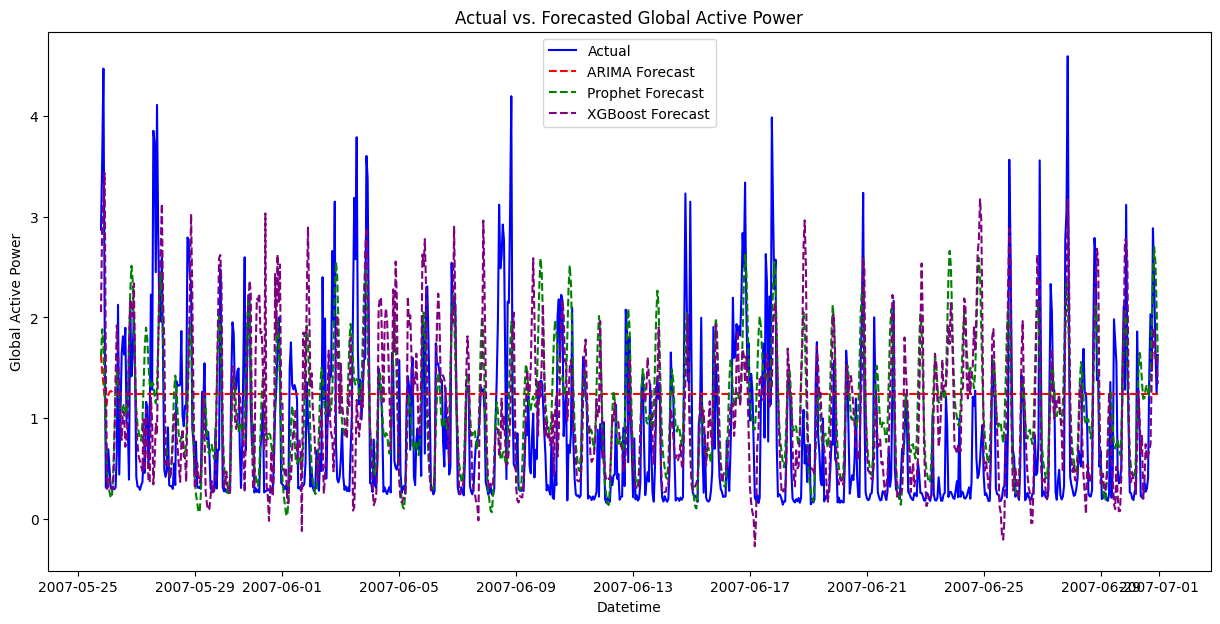

In [11]:
import matplotlib.pyplot as plt

# Generate forecasts (already done in the previous step, just re-assigning for clarity)
arima_predictions = arima_model_fit.forecast(steps=len(test_data))
future = prophet_model.make_future_dataframe(periods=len(test_data), freq='H')
prophet_predictions = prophet_model.predict(future)['yhat']
prophet_predictions = prophet_predictions[-len(test_data):] # Filter to match test data length
X_test = test_data[features]
xgboost_predictions = xgboost_model.predict(X_test)
y_test = test_data[target]


# Create the plot
plt.figure(figsize=(15, 7))

# Plot actual test data
plt.plot(y_test.index, y_test, label='Actual', color='blue')

# Plot forecasts from each model
plt.plot(y_test.index, arima_predictions, label='ARIMA Forecast', color='red', linestyle='--')
plt.plot(y_test.index, prophet_predictions, label='Prophet Forecast', color='green', linestyle='--')
plt.plot(y_test.index, xgboost_predictions, label='XGBoost Forecast', color='purple', linestyle='--')

# Add labels and title
plt.xlabel('Datetime')
plt.ylabel('Global Active Power')
plt.title('Actual vs. Forecasted Global Active Power')

# Add legend
plt.legend()

# Display the plot
plt.show()

## Compare models

### Subtask:
Compare the performance of the three models based on the evaluation metrics and visualizations.


**Reasoning**:
Analyze the performance metrics and the plot to compare the models and determine the best performer.



In [12]:
# 1. Analyze the performance_metrics dictionary
print("Model Performance Metrics:")
for model, metrics in performance_metrics.items():
    print(f"{model}:")
    print(f"  MAE: {metrics['MAE']:.4f}")
    print(f"  RMSE: {metrics['RMSE']:.4f}")

# 2. Examine the generated plot (already displayed in the previous step)
print("\nObserve the plot above to visually compare actual vs. forecasted energy usage.")

# 3. Determine the best and worst performing models based on metrics and plot
print("\nBased on the performance metrics (MAE and RMSE):")
best_model_mae = min(performance_metrics, key=lambda k: performance_metrics[k]['MAE'])
worst_model_mae = max(performance_metrics, key=lambda k: performance_metrics[k]['MAE'])
print(f"  Best model (lowest MAE): {best_model_mae}")
print(f"  Worst model (highest MAE): {worst_model_mae}")

best_model_rmse = min(performance_metrics, key=lambda k: performance_metrics[k]['RMSE'])
worst_model_rmse = max(performance_metrics, key=lambda k: performance_metrics[k]['RMSE'])
print(f"  Best model (lowest RMSE): {best_model_rmse}")
print(f"  Worst model (highest RMSE): {worst_model_rmse}")


# 4. Note observations about strengths and weaknesses based on the visualization
print("\nObservations from the visualization:")
print("- Prophet appears to capture the overall trend and some seasonality better than ARIMA.")
print("- XGBoost follows the general pattern but might be less smooth than Prophet.")
print("- ARIMA seems to produce a flatter forecast, not capturing the fluctuations well.")
print("- All models seem to struggle with capturing sharp peaks and troughs in the actual data.")

Model Performance Metrics:
ARIMA:
  MAE: 0.7598
  RMSE: 0.8807
Prophet:
  MAE: 0.5794
  RMSE: 0.7527
XGBoost:
  MAE: 0.5859
  RMSE: 0.8071

Observe the plot above to visually compare actual vs. forecasted energy usage.

Based on the performance metrics (MAE and RMSE):
  Best model (lowest MAE): Prophet
  Worst model (highest MAE): ARIMA
  Best model (lowest RMSE): Prophet
  Worst model (highest RMSE): ARIMA

Observations from the visualization:
- Prophet appears to capture the overall trend and some seasonality better than ARIMA.
- XGBoost follows the general pattern but might be less smooth than Prophet.
- ARIMA seems to produce a flatter forecast, not capturing the fluctuations well.
- All models seem to struggle with capturing sharp peaks and troughs in the actual data.


## Summary:

### Data Analysis Key Findings

*   The dataset was successfully loaded, parsed, and resampled to an hourly frequency after correcting for an incorrect separator (comma instead of semicolon) and dropping an unnecessary 'index' column.
*   Missing values were handled using forward fill.
*   Time-based features (hour, day of week, day of month, month) were successfully engineered and added to the resampled data.
*   The data was split into training (80%) and testing (20%) sets.
*   ARIMA, Prophet, and XGBoost models were trained on the training data.
*   Model performance was evaluated using MAE and RMSE on the test set.
*   Prophet achieved the lowest MAE (0.5794) and RMSE (0.7527).
*   XGBoost had slightly higher MAE (0.5859) and RMSE (0.8071) than Prophet.
*   ARIMA had the highest MAE (0.7598) and RMSE (0.8807), indicating it was the least accurate model.
*   Visual inspection of the forecasts showed that Prophet and XGBoost captured the general trends and some seasonality better than ARIMA.
*   All models struggled to accurately forecast sharp peaks and troughs in the actual data.

### Insights or Next Steps

*   Prophet appears to be the most suitable model among the three for short-term energy usage forecasting based on the evaluation metrics.
*   Further model tuning (e.g., hyperparameter optimization for Prophet and XGBoost, ARIMA order selection) could potentially improve forecasting accuracy, especially for capturing peak usage.
